# Model
> ###  _model_
verb/noun

    To both find patterns in a system, as well as the output of Machine Learning itself.
    "I modelled a ML model, so my model could model the future moments that I can then model."

<hr>

#### Now you have explored and found insights, and built your training set with all your features, it is time to build your model!
Even with so many intracacies, machine learning is surprisingly easy to start. It is, however, hard to master. This mastery however will come from your continue exposure and use - so don't worry right now! We will assume at this point that you have taken the time to fully understand you features and target, and will focus on model creation and some light evaluation (the focus of the next module - Measurement.)

Our focus in the third module will be creating a machine learning model using:
- **Pyspark**: Leveraging parallel cluster computing as simply as you would write SQL!
- **Spark ML Lib**: Create models where the big data is!
- **Scikit Learn**: A local machine learning package for python.


<hr>
<hr>

In [1]:
from utils import viz
import pyspark
from pyspark.sql.functions import * 
from pyspark.sql.types import *

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

sc_conf = SparkConf()
##Many more config options are available - set depending on your job!
sc_conf.setAll([('spark.executor.cores', 2)]).setAppName('Model')

spark = SparkSession.builder.config(conf = sc_conf).getOrCreate()
sc = spark.sparkContext

from IPython.core.display import display, HTML
url = sc._jsc.sc().uiWebUrl().get()
display(HTML('<a href = "{}" target = "_blank">Click here to open Spark UI</a>'.format(url)))

In [3]:
sdf = spark.read.parquet('Data/PreppedSet')

## Sampling/Partitioning

We are almost at the fun part I promise! Before we can tell how good our models are however, we need to plan a way to measure! The most basic way we can do this is splitting our dataset into a train & test set. This will allow us to build our model on training data, then test it on unseen data (test). A crucial element to measure of a machine learning model is its ability to generalise. Advanced concepts such as cross-validation & bagging will be tackled in the next lesson on deeper evaluation.

One simple way of splitting your data is randomly.

In [4]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 2019) ##We set seed to ensure replicability
train.count(), test.count()

(35659, 15020)

In [5]:
train.groupBy('Churn').count().show()
test.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|10256|
|    0|25403|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 4247|
|    0|10773|
+-----+-----+



The above is pretty balanced, but that might not always be the case.

Another is 'stratified sampling'. This approach attempts to ensure a similar proportion of the target in both train & test sets, but can also be used to over/undersample.

In [6]:
train = sdf.stat.sampleBy('Churn', {1:0.8, 0:0.8})
test = sdf.join(train.select('CustomerID'), on = 'CustomerID', how = 'left_anti')

In [7]:
train.groupBy('Churn').count().show()
test.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|11546|
|    0|28992|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 2925|
|    0| 7227|
+-----+-----+



## Dealing with Target Imbalance

When you are trying to model a rare event, you may have to deal with the skewed distribution - the fact that the 'negative' events outnumber the 'positive' ones by some large ratio.

This is because of a concept called the 'Accuracy Paradox'. This paradox can be exemplified as such - if your training set has a binary target in the ratio 9:1 (90% negative, 10% positive), a model can be produced that is 90% accurate with one rule - call everything negative. I.e. only predict the negative event.

You can see how absolutely useless this is and there are several approaches we can take to overcome this:
- penalise the model heavier for misclassifying positive/add weights
- undersample: reduce negative case samples
- oversample: duplicate (sample with replacement) the positive cases
- SMOTE/MSMOTE: synthesise/create new positive cases from noted patterns in the existing cases

And you should definitely not be using accuracy as your evaluation metric in these cases.

We will use undersampling below (reducing negative case). If you undersample to train, try and keep a true distribution in the 'test' data. Finally, do note that they don't need to be perfectly balanced - the more samples you have to train the model the more powerful it tends to be.

In [8]:
##Find our ratio of imbalance
ratio = sdf.filter(col('Churn')==1).count()/sdf.filter(col('Churn')==0).count()
print(ratio)

0.40090114993365766


In [9]:
##Take 70% of the set for Train
train1 = sdf.stat.sampleBy('Churn', {1:0.7, 0:0.7}, seed = 2019)

##Leave 30% for Test (just rules of thumb) at the pre-existing distribution.
test = sdf.join(train1.select('CustomerID'), on = 'CustomerID', how = 'left_anti')

##Reduce the negative samples by the ratio amount (40%)
train = train1.stat.sampleBy('Churn', {1:1, 0:ratio}, seed = 2019)

In [10]:
train.groupby('Churn').count().show()
test.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|10115|
|    0|10186|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 4388|
|    0|10834|
+-----+-----+



There are numerous other approaches, and each time you need to think deeply about the patterns you are teaching your model (from the train data) and testing its ability to generalise (from the test data).

Other techniques include:
- Time-based sampling: Such as training on Jan-March, and testing on April, to see if your model can generalise into the future. Valuable for forecast-style models.
- Group-based sampling: E.g. testing on existing areas to see if their patterns align with new areas.

We will use the balanced sets of train & test going forward, this helps the model not outweigh any particular class. This can occur on skewed data - if the event you are trying to predict happens in only 1% of the training set, your model can be 99% accurate by just predicting a non-event for every scenario.

## Modelling/Teaching them machines!

Now lets do our modelling! We will be using **CLASSIFICATION** models as our target is a binary yes/no variable. If we were predicting a continuous/numeric variables such as how much a customer might spend with us, we would use a **REGRESSION** model such as Linear Regression. We can also go past this into Multi-class classification, but that a bit advanced for our purposes. 

Same as when we were doing our string processing, and scaling, pyspark/spark follows the process of:
- Algorithm setup
- Fitting (Model creation)
- Transforming (Prediction/Inference creation)

#### Logistic Regression

(Not actually for regression but classification - always great to start in a confusing place!)

In [11]:
from pyspark.ml.classification import LogisticRegression

##Setting up our algorithm
lr = LogisticRegression(featuresCol ='scaledFeatures', labelCol = 'Churn')

##'Training' our model
lr_model = lr.fit(train)

##'Predicting' using our model
lr_predictions = lr_model.transform(test)

In [12]:
## Setting up our evaluator - it compares the label to the prediction and 
## can quickly produce different evaluation metrics.

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderROC")

In [13]:
##Running our evaluation on our test predictions
auc = evaluator.evaluate(lr_predictions)
print("Area Under the Curve (AUC) on test data = %g" % auc)

Area Under the Curve (AUC) on test data = 0.624279


In [14]:
lr_model.summary.areaUnderROC

0.6268962546268667

The second number is the AUC from our training set, the first from our test set. There is a point drop, but this is to be expected. As the model is trained on the training data (!), it builds all its rules based on the patterns it notices. So when we create our predictions on this set its unsurprising that it should perform better. If this gap was bigger (e.g. 90% on training vs 50% on test) it might indicate that our model is **overfitting** i.e. it is unable to generalise to cases it has not seen.

What if we use our non-scaled variables?

In [15]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol ='features', labelCol = 'Churn')
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)

auc = evaluator.evaluate(lr_predictions)
print("Area Under the Curve (AUC) on training data = %g" % lr_model.summary.areaUnderROC)
print("Area Under the Curve (AUC) on test data = %g" % auc)

Area Under the Curve (AUC) on training data = 0.626934
Area Under the Curve (AUC) on test data = 0.62431


Not alot of impact, and slightly better but note AUC is only one measurement variable - we will dive into these further in the next session.

How easily can we apply other algorithms with this construct? Let use our non-scaled features as it wont affect the following tree algorithms much.

#### Decision Tree

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Churn', seed = 2019)
dtModel = dt.fit(train)
predictionstr = dtModel.transform(train)
auctr = evaluator.evaluate(predictionstr)
predictions = dtModel.transform(test)
auc = evaluator.evaluate(predictions)
print("Area Under the Curve (AUC) on training data = %g" % auctr)
print("Area Under the Curve (AUC) on test data = %g" % auc)

Area Under the Curve (AUC) on training data = 0.634517
Area Under the Curve (AUC) on test data = 0.620641


#### Random Forest

In [17]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Churn', seed = 2019)
rfModel = rf.fit(train)
predictionstr = rfModel.transform(train)
auctr = evaluator.evaluate(predictionstr)
predictions = rfModel.transform(test)
auc = evaluator.evaluate(predictions)
print("Area Under the Curve (AUC) on training data = %g" % auctr)
print("Area Under the Curve (AUC) on test data = %g" % auc)

Area Under the Curve (AUC) on training data = 0.665279
Area Under the Curve (AUC) on test data = 0.639436


#### Gradient Boosted Trees

In [18]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'Churn', seed = 2019)
gbtModel = gbt.fit(train)
predictionstr = gbtModel.transform(train)
auctr = evaluator.evaluate(predictionstr)
predictions = gbtModel.transform(test)
auc = evaluator.evaluate(predictions)
print("Area Under the Curve (AUC) on training data = %g" % auctr)
print("Area Under the Curve (AUC) on test data = %g" % auc)

Area Under the Curve (AUC) on training data = 0.738622
Area Under the Curve (AUC) on test data = 0.660625


#### Multilayer Perceptron (Neural Net)

In [19]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

##First layer needs to be the size of the feature set
layers = [train.schema["features"].metadata["ml_attr"]["num_attrs"], 20, 10, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(featuresCol = 'features',
                                         labelCol = 'Churn',
                                         layers=layers, seed = 2019)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
predictionstr = model.transform(train)
auctr = evaluator.evaluate(predictionstr)
predictions = model.transform(test)
auc = evaluator.evaluate(predictions)
print("Area Under the Curve (AUC) on training data = %g" % auctr)
print("Area Under the Curve (AUC) on test data = %g" % auc)

Area Under the Curve (AUC) on training data = 0.610657
Area Under the Curve (AUC) on test data = 0.607433


So multiple things to take away here:
- We can easily test multiple algorithms (and we can do it programmatically too - more in next lesson!)
- They result in a tangible prediction difference - while all of our results sat between 60% & 70% AUC, if these predictions can prevent a costly mistake, 5% difference could be millions of dollars in savings/revenue.
- We can run our trained models on new data! 

In fact there are even more things we can do
- Change hyperparameters - so far we have used the defaults, but this is where your understanding of each individual model comes into play. For each Decision Tree algorithm, you can pick the depth of the branches, how many splits each can have etc. These can be powerful tuning considerations (which again we will programmatically explore next session).
- Save, and reload model or even the whole pipeline - You saw when we ran our string encodings etc, that we built what is called a 'pipeline' - we can include a model in this, and save out this entire pipeline to be loaded later. It will allow us to run our tail end data prep (likely you will have feature engineering need to occur prior, but it still simplifies alot!) and prediction creation again much easier.

We will quickly save and reload our GBT (Gradient Boosted Trees) Model to show how it can work.

<hr>

In [20]:
gbtModel.write().overwrite().save("Model/GBT")
##Can use model.write().overwrite().save() if you need to overwrite an old one.

In [21]:
from pyspark.ml.classification import GBTClassificationModel
sameModel = GBTClassificationModel.load("Model/GBT")

In [22]:
predictions = sameModel.transform(test)
auc = evaluator.evaluate(predictions)
print("Area Under the Curve (AUC) on test data = %g" % auc)

Area Under the Curve (AUC) on test data = 0.660622


It worked! Same AUC value too. Note that you can lose some training summary details when you save out a model - it assumes you purely need the rules to create predictions in production. So for additional things such as training time etc - it may be worth saving this out separately, or completing your analysis prior to process shutdown.

## Feature Selection

One method of feature selection is find features with an 'importance' of 0 (or low importance) and removing them, as they can just create noise and as mentioned in a previous lesson, multicollinearity (correlated variables) can be a problem for many models.

Another way is using dimensionality reduction techniques such as PCA.

#### Feature Importance

In [23]:
featImp = gbtModel.featureImportances ##Can use loaded model too - sameModel.featureImportances

In [24]:
##Can use either train or test, but we are aligning the importance values with their variables
meta = [f.metadata 
    for f in test.schema.fields 
    if f.name == 'features'][0]

# access feature name and index
features_name_ind = meta['ml_attr']['attrs']['numeric'] + \
    meta['ml_attr']['attrs']['binary']

feats = [x.get('name') for x in features_name_ind]

In [25]:
feats[0]

'MonthlyRevenue'

In [26]:
len(feats)==len(featImp)

True

In [27]:
import pandas as pd
fi = pd.DataFrame({'name':feats, 'val':featImp})

fi.sort_values('val', ascending = False)[:10]

,name,val
6,PercChangeMinutes,0.073500
26,CurrentEquipmentDays,0.066695
21,MonthsInService,0.063833
1,MonthlyMinutes,0.063812
2,TotalRecurringCharge,0.048974
27,AgeHH1,0.047502
7,PercChangeRevenues,0.045092
37,OverPay,0.033634
34,AvgMinsArea,0.031139
35,MedianRevArea,0.028922


Tada! We have our top ten feature importances!

#### PCA

PCA (Principal Components Analysis) essentially finds which variables explain the variance in a dataset best, compressing those correlated variables together into 'Principal Components' (eigenvectors), which may allow us to distill the patterns in hundreds of variables into 10.

You will note that we do not align this to our target variable - just because this method compresses the variance of the set, it doesn't necessarily mean the variance of our target will be well represented.

You will want scaled features here - linear differences in scaling will result in arbitrarily larger variables taking precedence (e.g. millions of dollars vs a meter). Again, all of these pyspark steps can form a pipeline which can all be run prior to training/inference. While we are looking into these techniques after, to help you see the iterative nature of this process, in automating future inferences, these pieces occur before training and saving your final model.

In [28]:
##K is how many principal components you wish to combine all your variables into.

from pyspark.ml.feature import PCA

pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(sdf)

result = pcaModel.transform(sdf)
result.select("pcaFeatures").show(2, truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[-1.4924069542207303,1.752637287818768,-5.042042484519494] |
|[0.34100625109068156,2.2749594681775074,0.2416842744724213]|
+-----------------------------------------------------------+
only showing top 2 rows



In [29]:
pcaModel.explainedVariance

DenseVector([0.1435, 0.0883, 0.0391])

The above shows us that our variables don't collectively identify patterns for our target well - it is saying that if we transform all our features into 3, the first would explain 14% of the variance in Churn, the second 9% and third 4%. Ideally for a powerful PCA transformation, we would be looking for that first one to cover ~60% of the variance (RULE OF THUMB, not an actual rule). 

In this case, if we dropped all our other variables and kept just these 3, we would be even worse at predicting churn. This could be a good early sign that we need different features, data, or problem!

However, lets view our Churn problem through the lens of these PCs to see if they can break apart our classes. We are using test so we don't bring the entire 50k rows into a visual.

In [31]:
# smaller = pcaModel.transform(test).select('Churn', 'pcaFeatures')

# ##Allows us to break out the single column list into 3 columns, one for each component.
# def to_array_(v):
#         return v.toArray().tolist()
# to_array = udf(to_array_, ArrayType(DoubleType()))

# sm = smaller.\
#     withColumn("pc", to_array(col("pcaFeatures"))).\
#     select(["Churn"] + [col("pc")[i].alias("pc"+str(i)) for i in range(3)]).\
#     withColumn('Churn', when(col('Churn')==1, 'Churn').otherwise('Stay')).toPandas()

# sm[:5]

In [32]:
# viz.plotlys(sm[:500], 'pc0', 'pc1', kind = 'Scat', group = 'Churn')

Pretty messy!

### ChiSq

As we did before - we can also run statistics to see which of our variables seem more correlated/aligned with our target - we can use ChiSq again, but this time using the vectorised version.

In [33]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector

indexed_cols = [x for x in sdf.columns if x[-2:] =="_i"]

func_cols = ['CustomerID', 'Churn']
assembler = VectorAssembler(
    inputCols = indexed_cols,
    outputCol = "features2")
sdfc = assembler.transform(sdf).select(func_cols+['features2'])


selector = ChiSqSelector(numTopFeatures = 5, featuresCol = "features2",
                         outputCol = "selectedFeatures", labelCol = "Churn")

features = selector.fit(sdfc).selectedFeatures

# print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
# result.show()

In [34]:
for feat in features:
    print(indexed_cols[feat])

HandsetWebCapable_i
MadeCallToRetentionTeam_i
CreditRating_i
HandsetRefurbished_i
MaritalStatus_i


In [35]:
sdf.groupBy('HandsetWebCapable', 'Churn').count().show()

+-----------------+-----+-----+
|HandsetWebCapable|Churn|count|
+-----------------+-----+-----+
|              Yes|    0|33088|
|               No|    1| 1829|
|              Yes|    1|12674|
|               No|    0| 3088|
+-----------------+-----+-----+



In [36]:
12662/(33078+12662), 1829/(1829+3086)

(0.27682553563620466, 0.3721261444557477)

We can see that those with a handset that isn't able to go on the web have 10% more customers churning than those with web handsets. Let's dig further to remind ourselves that we need to focus on the BUSINESS OUTCOME - maybe we dont care? Maybe those with a web capable phone are also on cheaper plans & thus we will decide not to spend monery keeping them?

In [37]:
sdf.groupBy('HandsetWebCapable').agg(mean('MonthlyRevenue')).show()

+-----------------+-------------------+
|HandsetWebCapable|avg(MonthlyRevenue)|
+-----------------+-------------------+
|               No| 45.181199918649355|
|              Yes|  60.36219701936662|
+-----------------+-------------------+



$15 dollars less! 

So in a simple example where it is costing us 40 dollars to support a user, if we were to give likely churn customers a 5 dollar discount, we may remove all profit for us. Obviously this is super simplistic and ignores lifetime value and so on, but something to consider!

---

## Clustering

We could've used PCA to cluster our customers, but no luck. There are other clustering algorithms we can try though - how about k-means?

In [38]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#k here is the number of clusters, or more accurately the number of cluster centers for every row 
# to be measured against.
kmeans = KMeans(k=5, seed=1, featuresCol = 'scaledFeatures', 
                predictionCol = 'Cluster')  # 5 clusters here
kmodel = kmeans.fit(sdf)

In [39]:
transformed = kmodel.transform(sdf)
transformed.select('Churn', 'scaledFeatures', 'Cluster').limit(5).toPandas()   

,Churn,scaledFeatures,Cluster
0,1,"(0.5391925583543162, 0.41318652237144715, 0.92...",3
1,1,"(0.38170339860165964, 0.0188669644918469, 0.71...",3
2,0,"(0.8537215507276674, 0.01509357159347752, 1.59...",3
3,0,"(1.8485318208913808, 2.4753457413303135, 3.147...",1
4,1,"(0.38507335209137417, 0.0, 0.7135279860791929,...",3


So 5 clusters have been assigned, but how useful are they?

In [40]:
evaluator = ClusteringEvaluator(featuresCol = 'scaledFeatures', predictionCol = 'Cluster')

silhouette = evaluator.evaluate(transformed)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.059911966873872936


A value of 1 is ideal - a value of 0.132 indicates that our clusters are very close to each other, and the points within a cluster are very spread out.

In [41]:
##Can use either train or test, but we are aligning the importance values with their variables
centers = kmodel.clusterCenters()
cntrs = pd.DataFrame({'names':feats})
for i, center in enumerate(centers):
    
    cntrs = cntrs.join(pd.DataFrame({('clust'+str(i)):center}))
cntrs[:10]

,names,clust0,clust1,clust2,clust3,clust4
0,MonthlyRevenue,1.118047,3.083216,1.218872,1.000651,1.155836
1,MonthlyMinutes,0.722453,3.033596,0.925923,0.592274,0.788496
2,TotalRecurringCharge,1.808251,3.182517,1.951899,1.696689,1.859514
3,DirectorAssistedCalls,0.300421,1.353647,0.336080,0.234880,0.309939
4,OverageMinutes,0.248430,1.861126,0.293194,0.186570,0.271170
5,RoamingCalls,0.109691,0.402121,0.110111,0.079673,0.090320
6,PercChangeMinutes,-0.016014,-0.282858,-0.033542,-0.013078,-0.008915
7,PercChangeRevenues,-0.008474,-0.214759,-0.017254,-0.005003,-0.006038
8,DroppedCalls,0.410590,2.247660,0.591738,0.370876,0.524446
9,BlockedCalls,0.261802,1.300297,0.315805,0.234937,0.260925


The above lets us understand our average cluster differences (obviously with our centers scaled, like the feature input was). With this we can make generalisations like 'customers in cluster 3 spend more money (with a MonthlyRevenue centroid of 5.38 vs ~1).

In [42]:
from pyspark.sql.window import Window
transformed.groupBy('Cluster', 'Churn').count().\
    withColumn('perc', 
               col('count')/sum(col('count')).over(Window.partitionBy('Cluster'))).\
    withColumn('total', 
               sum(col('count')).over(Window.partitionBy('Cluster'))).\
    filter(col('Churn')==1).orderBy('Cluster').toPandas()

,Cluster,Churn,count,perc,total
0,0,1,1168,0.285296,4094
1,1,1,1307,0.252025,5186
2,2,1,3854,0.303297,12707
3,3,1,3942,0.282015,13978
4,4,1,4232,0.287617,14714


Above shows us how many customers are in each cluster, and the Churn Percentage per cluster, again helping us decide if this is useful for our efforts in understanding Churn. For example, clusters 1 & 2 might be too small. Cluster 0 & 1 may have too similar a churn pattern to be useful. On the other hand, we can combine clusters 3&4 for low churners, and 0,1,2 as high churners for further analysis.

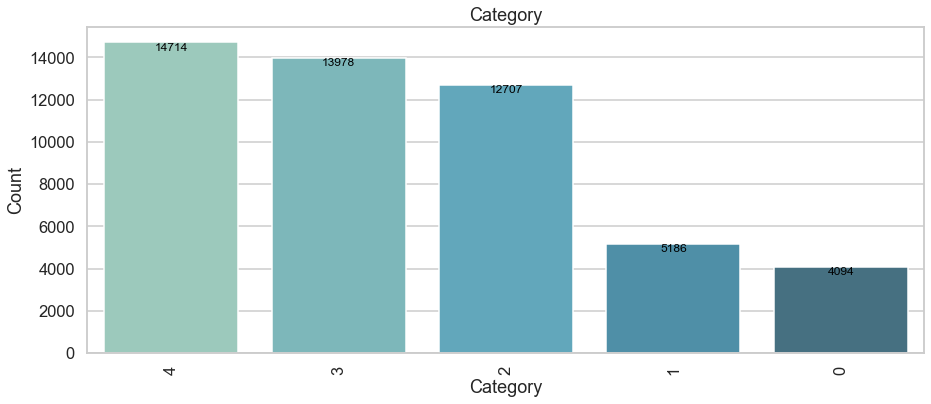

In [43]:
viz.spark_category_viz(transformed.withColumn('Cluster', 
                                              col('Cluster').cast(StringType())), #to string just to be treated as categories
                       'Cluster')

Let's quickly try BisectingKMeans - essentially heirachial clustering.

In [44]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator


bkm = BisectingKMeans(k=5, seed=1, featuresCol = 'scaledFeatures', 
                predictionCol = 'Cluster')
bmodel = bkm.fit(sdf)

# Evaluate clustering.
cost = bmodel.computeCost(sdf)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 3037488.2200854486


In [45]:
evaluator = ClusteringEvaluator(featuresCol = 'scaledFeatures', predictionCol = 'Cluster')

silhouette = evaluator.evaluate(bmodel.transform(sdf))
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.09511031699032746


Even lower! Remember we can always play with our 'k' hyperparameter - perhaps we need more clusters to accurately separate. If we remember our exploration however, we remember there are alot of skewed variables - e.g. monthly minutes. Most people have a normal amount of minutes, and then there are outliers. These can easily be clustered, but the 95% of customers with a standard behaviour become harder to separate.

----
----

Loads to take in this lesson, lots of tactics, techniques, and thoughts.

We will be revisiting the modelling construct next session however when we talk hyperparameters, cross-validation, & evaluation.

---
---

***Samuel Mitchell* 2019**
<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>

### Appendix: PCA EigenValues

In [46]:
pcsplit = pcaModel.pc

In [47]:
pcs = pd.DataFrame(pcsplit.toArray())

In [48]:
pcs.columns = ['PC0', 'PC1', 'PC2']
pcs['var'] = feats

pcs[:10]

,PC0,PC1,PC2,var
0,-0.231035,0.119661,0.041782,MonthlyRevenue
1,-0.264729,0.109334,0.040277,MonthlyMinutes
2,-0.173337,0.071763,0.030472,TotalRecurringCharge
3,-0.129118,0.071164,-0.002439,DirectorAssistedCalls
4,-0.185747,0.110943,0.047156,OverageMinutes
5,-0.041659,0.026006,0.026334,RoamingCalls
6,0.028873,-0.015359,0.004955,PercChangeMinutes
7,0.020395,-0.012124,0.011882,PercChangeRevenues
8,-0.199972,0.078449,0.024632,DroppedCalls
9,-0.116795,0.057448,0.050280,BlockedCalls


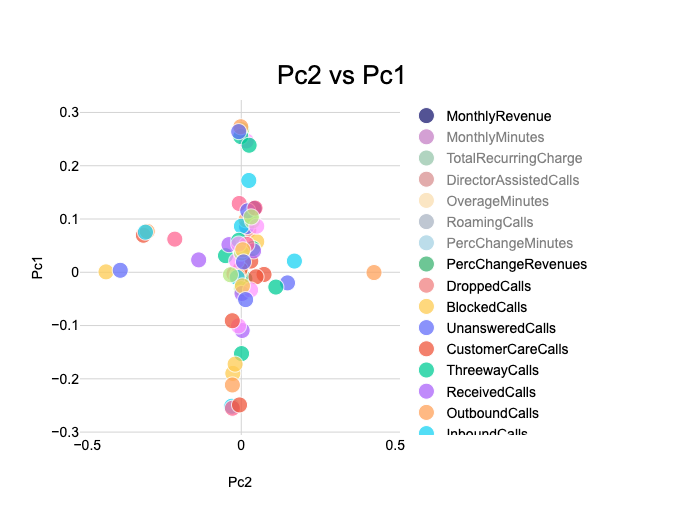

In [49]:
viz.plotlys(pcs, 'PC2', 'PC1', kind = 'Scat', group = 'var', width = 800)

### Appendix In-Memory Sci-Kit Learn

In [50]:
## This would not be possible with a standard set - we have a small set of 50k, we can 
## bring into memory and work on it. It is why below we will teach you "pyspark" techniques,
## but sci-kit learn may open your options.
skl_cols = [t[0] for t in sdf.dtypes if not (t[1].startswith('vector')) and not (t[0].endswith('_i'))]
df = sdf.select(skl_cols).toPandas()
#df = sdf.drop('features', 'scaledFeatures')

In [51]:
df.Churn.value_counts()

0    36176
1    14503
Name: Churn, dtype: int64

In [52]:
## This will allow us to turn our strings into dummy variables (binary one hot encoding)
import pandas as pd
df = pd.get_dummies(df, drop_first = True)

In [53]:
##Sampling/Partitioning

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis = 1), df.Churn,
                                                test_size=0.3, random_state=0)


In [54]:
from sklearn.linear_model import LogisticRegression

# There are three steps to model something with sklearn
# 1. Set up the model
model = LogisticRegression(solver = 'lbfgs')
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
model.score(X_test, y_test)

0.7085635359116023

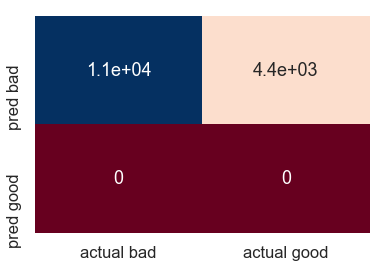

In [55]:
from sklearn import metrics
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_pred, y_test)

import seaborn as sns
sns.heatmap(cm, annot=True, xticklabels = ['actual bad', 'actual good'], yticklabels =['pred bad', 'pred good'], 
            cbar=False, cmap="RdBu")

Great example of how a skewed set can affect your model - it didn't cost the model to say ALL of the 'good' was bad, so it did.

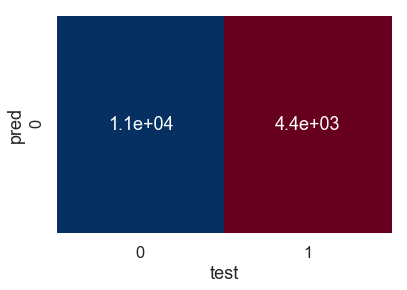

In [56]:
compare = pd.DataFrame({'pred':y_pred, 'test':y_test})

df2 = compare.groupby(['pred', 'test']).size().rename('count').reset_index()
dfp = df2.pivot(index='pred', columns='test', values='count')
sns.heatmap(dfp, annot = True, cbar=False, cmap="RdBu")

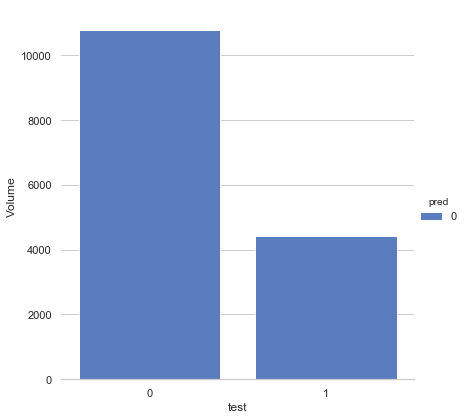

In [57]:
import seaborn as sns
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="test", y="count", hue="pred", data=df2,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Volume")

In [58]:
df = sdf.select(skl_cols).stat.sampleBy('Churn', {1:1, 0:0.4}, 2019).toPandas()
df = pd.get_dummies(df, drop_first = True)

In [59]:
##Sampling/Partitioning

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis = 1), df.Churn,
                                                test_size=0.3, random_state=0)

# 1. Set up the model
model = LogisticRegression(solver = 'lbfgs')
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
model.score(X_test, y_test)

0.49260405916752664

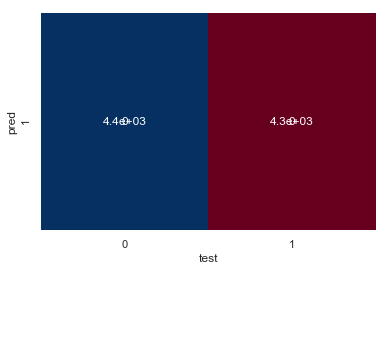

In [60]:
from sklearn import metrics
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_pred, y_test)

import seaborn as sns
sns.heatmap(cm, annot=True, xticklabels = ['actual bad', 'actual good'], yticklabels =['pred bad', 'pred good'], 
            cbar=False, cmap="RdBu")
compare = pd.DataFrame({'pred':y_pred, 'test':y_test})

df2 = compare.groupby(['pred', 'test']).size().rename('count').reset_index()
dfp = df2.pivot(index='pred', columns='test', values='count')
sns.heatmap(dfp, annot = True, cbar=False, cmap="RdBu")

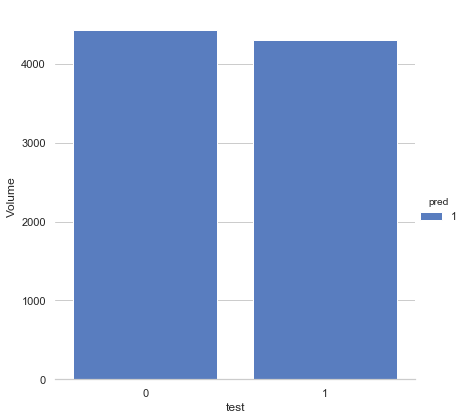

In [61]:
import seaborn as sns
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="test", y="count", hue="pred", data=df2,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Volume")

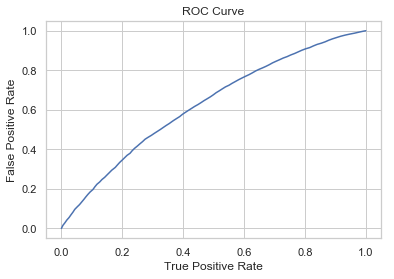

Training set areaUnderROC: 0.6265530715513108


In [66]:
from matplotlib import pyplot as plt
trainingSummary = lr_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

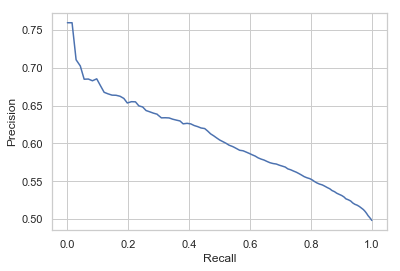

In [67]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [73]:
from xgboost import XGBClassifier
clf = XGBClassifier()
# n_estimators = 100 (default)
# max_depth = 3 (default)
clf.fit(X_train,y_train)
preds2 = clf.predict(X_test)

In [77]:
from sklearn import metrics
cm = metrics.confusion_matrix(preds2, y_test)

cm

array([[2612, 1586],
       [1813, 2710]])

<hr>
<hr>

# Scikit Learn Modelling (Locally/In Memory)

## Linear Regression 
As discussed, regression is for continuous variables. At this point, after Muddle and Make, you should have a pretty darn good understanding of your features and target. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import datasets

In [ ]:
diabetes = datasets.load_diabetes()

In [ ]:
#Remember to separate features & target for sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, 
                                                    diabetes.target, 
                                                    test_size=0.2, 
                                                    random_state=0) #simply a 'seed' to recreate the randomness consistently

In [ ]:
# There are three steps to model something with sklearn
# 1. Set up the model
model = LinearRegression()
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
model.score(X_test, y_test)

In [ ]:
#Inference
model.predict(X_test)[:3]

In [ ]:
y_pred = model.predict(X_test) 
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 330, 100)
y = x
plt.plot(x, y)
plt.show()

## Logistic Regression
Actually for classification - essentially you have two labels (and can expand into multi-class classification) and we try to predict between the two!

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes.data, 
                                                    np.where(diabetes.target>150, 'bad', 'good'), 
                                                    test_size=0.2, random_state=0)


In [ ]:
# There are three steps to model something with sklearn
# 1. Set up the model
model = LogisticRegression(solver = 'lbfgs')
# 2. Use fit
model.fit(X_train, y_train)
# 3. Check the score
model.score(X_test, y_test)

In [ ]:
from sklearn import metrics
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_pred, y_test)

import seaborn as sns
sns.heatmap(cm, annot=True, xticklabels = ['actual bad', 'actual good'], yticklabels =['pred bad', 'pred good'], 
            cbar=False, cmap="RdBu")

In [ ]:
compare = pd.DataFrame({'pred':y_pred, 'test':y_test})

df = compare.groupby(['pred', 'test']).size().rename('count').reset_index()
dfp = df.pivot(index='pred', columns='test', values='count')
sns.heatmap(dfp, annot = True, cbar=False, cmap="RdBu")

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="test", y="count", hue="pred", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

# Spark MLLib

In [ ]:
import pandas as pd
data = pd.concat([pd.DataFrame(diabetes.data, columns = diabetes.feature_names),
              pd.DataFrame(pd.Series(diabetes.target).rename('target'))], 
          sort = False, axis = 1)


In [ ]:
sdf = spark.createDataFrame(data)

In [ ]:
import pandas as pd
numeric_features = [t[0] for t in sdf.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = sdf.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [x for x in sdf.columns if x!='target'], outputCol = 'features')
v_df = vectorAssembler.transform(sdf)
#v_df = v_df.select(['features', 'target'])

splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
import six
for i in sdf.columns:
    if not( isinstance(sdf.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to target for ", i, sdf.stat.corr('target',i))

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='target', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

In [ ]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","target","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="target",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

In [ ]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

In [ ]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.limit(5).show()

In [ ]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","target","features").limit(5).show()

### Decision Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'target')

dt_model = dt.fit(train_df)

dt_predictions = dt_model.transform(test_df)

dt_evaluator = RegressionEvaluator(
    labelCol="target", predictionCol="prediction", metricName="rmse")

rmse = dt_evaluator.evaluate(dt_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'target', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'target', 'features').show(5)

In [ ]:
gbt_evaluator = RegressionEvaluator(
    labelCol="target", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

### Classification

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

dt = LogisticRegression(featuresCol ='features', labelCol = 'target')

dt_model = dt.fit(train_df.withColumn('target', when(col('target')>150, 0).otherwise(1)))

dt_predictions = dt_model.transform(test_df.withColumn('target', when(col('target')>150, 0).otherwise(1)))

dt_evaluator = BinaryClassificationEvaluator(
    labelCol="target", rawPredictionCol="probability", metricName="areaUnderROC")

auc = dt_evaluator.evaluate(dt_predictions)

print("Area Under the Curve (AUC) on test data = %g" % auc)

### Clustering

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=5, seed=1)  # 5 clusters here
model = kmeans.fit(v_df.select('features'))

In [ ]:
transformed = model.transform(v_df)
transformed.limit(5).toPandas()   

In [ ]:
viz.spark_category_viz(transformed.withColumn('prediction', 
                                              col('prediction').cast(StringType())), #to string just to be treated as categories
                       'prediction', 'clusters')

In [ ]:
group = viz.spark_continuous_viz(transformed, #.withColumn('bmi', round(col('bmi'), 3)), #.withColumn('age', col('age')*100), 'age', 
                                 'target',
                               result_name = 'buck', num_buckets=5,
                        description=False, plot = False)


In [ ]:
base = group.groupBy('buck', 'prediction').count().toPandas()
base['prediction'] = base['prediction'].astype(str)

df = base.groupby(['prediction', 'buck']).agg({'count': 'sum'})
df = df.groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()))).reset_index()
df.sort_values('buck')[:2]

In [ ]:
viz.plotlys(df, x = 'prediction', y = 'count', group='buck', kind = 'Bar', 
               title = 'Cluster vs BMI', xtitle = 'Cluster')

In [ ]:
for i in sdf.columns:
    if not( isinstance(sdf.select(i).take(1)[0][0], six.string_types)):

        group = viz.spark_continuous_viz(transformed.withColumn(i, round(col(i)*100, 0)),
                         i,
                           result_name = 'buck', num_buckets=5,
                    description=False, plot = False)
        base = group.groupBy('buck', 'prediction').count().toPandas()
        base['prediction'] = base['prediction'].astype(str)
        df = base.groupby(['prediction', 'buck']).agg({'count': 'sum'})
        df = df.groupby(level = 0).apply(lambda x: np.round(100 * x / float(x.sum()))).reset_index()
        base['buck'] = base['buck'].astype(int)
        df.sort_values('buck', inplace = True)
        base['buck'] = base['buck'].astype(str)

        viz.plotlys(df, x = 'prediction', y = 'count', group='buck', kind = 'Bar', 
               title = 'Cluster vs {}'.format(i), xtitle = 'Cluster', ytitle = 'Percent', stacked = True)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

In [ ]:
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression(maxIter=10, regParam=.01)

stages = [vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)
#https://blog.epigno.systems/2018/02/18/machine-learning-with-pyspark-linear-regression/

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:




from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV ## save for 'evaluation'?

lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(x, y)

scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# #############################################################################
# Bonus: how much can you trust the selection of alpha?

# To answer this question we use the LassoCV object that sets its alpha
# parameter automatically from the data by internal cross-validation (i.e. it
# performs cross-validation on the training data it receives).
# We use external cross-validation to see how much the automatically obtained
# alphas differ across different cross-validation folds.
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=0)
k_fold = KFold(3)

print("Answer to the bonus question:",
      "how much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    lasso_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(X[test], y[test])))
print()
print("Answer: Not very much since we obtained different alphas for different")
print("subsets of the data and moreover, the scores for these alphas differ")
print("quite substantially.")

plt.show()

---
---

